In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import pathlib
import pandas as pd

seed_ = 42

dim = 16
directory = pathlib.Path("../events/MG3")

n_3b = 250000
n_all4b = 250000

# shortcut: load short and shuffled version data

df_3b = pd.read_hdf(directory / "dataframes" / f"threeTag_picoAOD_{n_3b}.h5")
df_bg4b = pd.read_hdf(directory / "dataframes" / f"fourTag_10x_picoAOD_{n_all4b}.h5")
df_hh4b = pd.read_hdf(directory / "dataframes" / f"HH4b_picoAOD_{n_all4b}.h5")

df_3b["signal"] = False
df_bg4b["signal"] = False
df_hh4b["signal"] = True

print("3b-jet events: ", len(df_3b))
print("4b-jet events: ", len(df_bg4b))
print("HH4b-jet events: ", len(df_hh4b))

3b-jet events:  250000
4b-jet events:  250000
HH4b-jet events:  30856


In [4]:
# Training 

from split_samples import split_samples
from fvt_classifier import FvTClassifier
from torch.utils.data import DataLoader, TensorDataset
from fvt_representations import get_fvt_reprs
from plots import plot_prob_weighted_histogram1d, calibration_plot
import numpy as np
import pytorch_lightning as pl

features = ["sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
            "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
            "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",
            "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m"]

signal_ratio = 0.05
###########################################################################################
###########################################################################################
pl.seed_everything(seed_)
np.random.seed(seed_)

test_ratio = 0.5

n_3b_train = int(n_3b * (1 - test_ratio))
n_all4b_train = int(n_all4b * (1 - test_ratio))
n_bg4b_train = n_all4b_train - int(n_all4b_train * signal_ratio)
n_hh4b_train = int(n_all4b_train * signal_ratio)

df_3b_train = df_3b.iloc[:n_3b_train]
df_bg4b_train = df_bg4b.iloc[:n_bg4b_train]
df_hh4b_train = df_hh4b.iloc[:n_hh4b_train]
# reweight to match signal_ratio
df_hh4b_train.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_train["weight"]) / np.sum(df_hh4b_train["weight"])) * df_hh4b_train["weight"]
df_train = pd.concat([df_3b_train, df_bg4b_train, df_hh4b_train])
# shuffle the data
df_train = df_train.sample(frac=1, random_state=seed_).reset_index(drop=True)

n_3b_test = n_3b - n_3b_train
n_all4b_test = n_all4b - n_all4b_train
n_bg4b_test = n_all4b_test - int(n_all4b_test * signal_ratio)
n_hh4b_test = int(n_all4b_test * signal_ratio)

df_3b_test = df_3b.iloc[n_3b_train:n_3b_train+n_3b_test]
df_bg4b_test = df_bg4b.iloc[n_bg4b_train:n_bg4b_train+n_bg4b_test]
df_hh4b_test = df_hh4b.iloc[n_hh4b_train:n_hh4b_train+n_hh4b_test]
df_hh4b_test.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_test["weight"]) / np.sum(df_hh4b_test["weight"])) * df_hh4b_test["weight"]
df_test = pd.concat([df_3b_test, df_bg4b_test, df_hh4b_test])
df_test = df_test.sample(frac=1, random_state=seed_).reset_index(drop=True)

# reduce number of 4b samples to 1/8
print("4b ratio: ", df_train.loc[df_train["fourTag"], "weight"].sum() / df_train["weight"].sum())
print("Signal ratio: ", df_train.loc[df_train["signal"], "weight"].sum() / df_train.loc[df_train["fourTag"], "weight"].sum())

(
    (X_train, w_train, y_train, is_signal_train), 
    (X_val, w_val, y_val, is_signal_val), 
) = split_samples(
    df_train[features].values, df_train["weight"].values, df_train["fourTag"].values, df_train["signal"].values, 
    at=2/3, div=1024, seed=seed_)

end_at = 1024 * (len(df_test) // 1024)
X_test = df_test[features].values[:end_at]
w_test = df_test["weight"].values[:end_at]
y_test = df_test["fourTag"].values[:end_at]
is_signal_test = df_test["signal"].values[:end_at]


train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                            torch.tensor(y_train, dtype=torch.long),
                            torch.tensor(w_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.long),
                            torch.tensor(w_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                            torch.tensor(y_test, dtype=torch.long),
                            torch.tensor(w_test, dtype=torch.float32))

###########################################################################################
###########################################################################################


num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 50
run_name = "_".join(["fvt_picoAOD", 
                    f"signal_ratio={signal_ratio}", 
                    f"dijet={dim_dijet_features}", 
                    f"quadjet={dim_quadjet_features}", 
                    f"n_3b={n_3b}",
                    f"n_all4b={n_all4b}",
                    f"epochs={max_epochs}",
                    f"seed={seed_}",
                    ])
lr = 1e-3

Seed set to 42


4b ratio:  0.4770373
Signal ratio:  0.049999997


In [5]:
print("Test Data")

from torch.utils.data import DataLoader

end_at = 1024 * (df_test.index.size // 1024)

(X_test, w_test, y_test, is_signal_test), _ = split_samples(
    df_test[features].values, df_test["weight"].values, df_test["fourTag"].values, df_test["signal"].values,
    at=1, div=1024, seed=seed_)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)
w_test_torch = torch.tensor(w_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_torch, y_test_torch, w_test_torch)

fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)
device = torch.device("cuda:0")
fvt_model = fvt_model.to(device)

q_repr_test, view_scores_test = get_fvt_reprs(X_test_torch, fvt_model, device)
labels_4b_test = y_test
probs_4b_test = fvt_model.predict(X_test_torch)[:, 1].cpu().numpy()

is_3b_test = labels_4b_test == 0
is_4b_test = labels_4b_test == 1
is_bg4b_test = (labels_4b_test == 1) & (is_signal_test == 0)
is_hh4b_test = (labels_4b_test == 1) & (is_signal_test == 1)

Test Data


**Test Data**


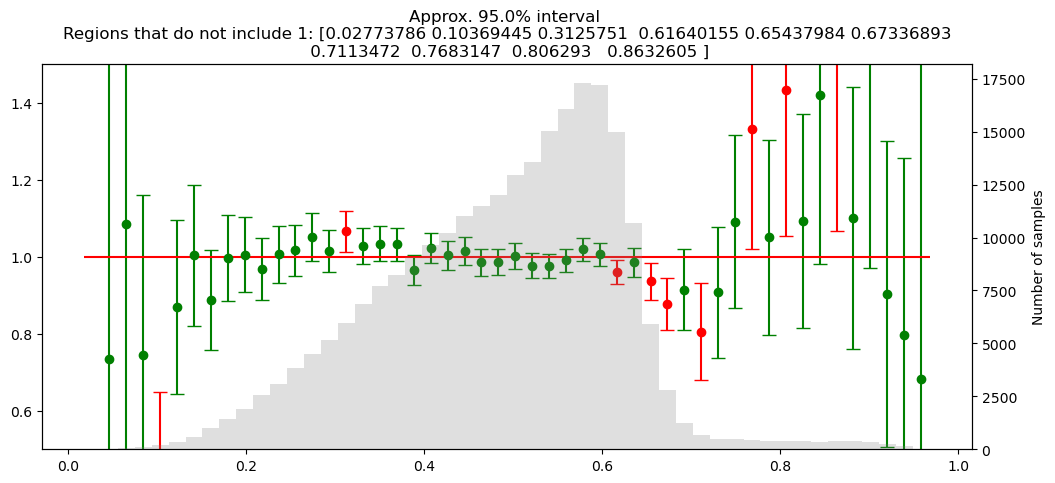

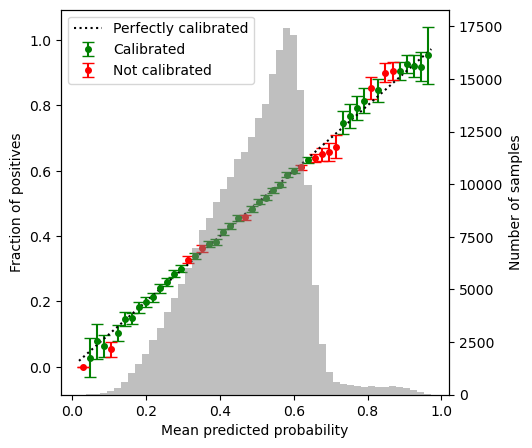

In [6]:
print("**Test Data**")


plot_prob_weighted_histogram1d(probs_4b_test, probs_4b_test, labels_4b_test,
                               n_bins=50, 
                               sample_weights=w_test,
                               ylim=(0.5, 1.5))
calibration_plot(probs_4b_test, labels_4b_test,
                 bins=50,
                 sample_weights=w_test)

/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Thresholded samples
3b:  1783
bg4b:  2745
hh4b:  472


/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


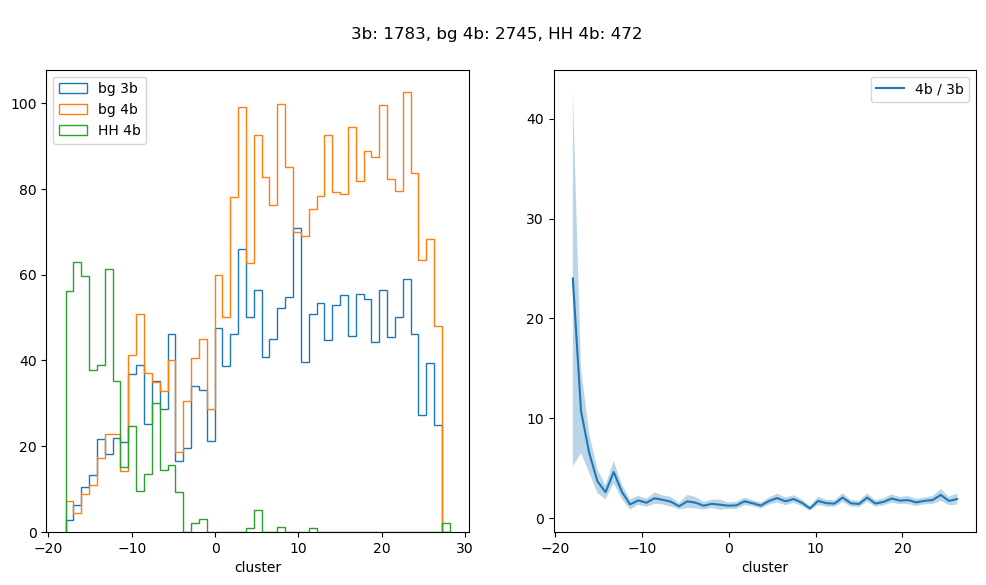

Failed samples
3b:  108366
bg4b:  92837
hh4b:  1721


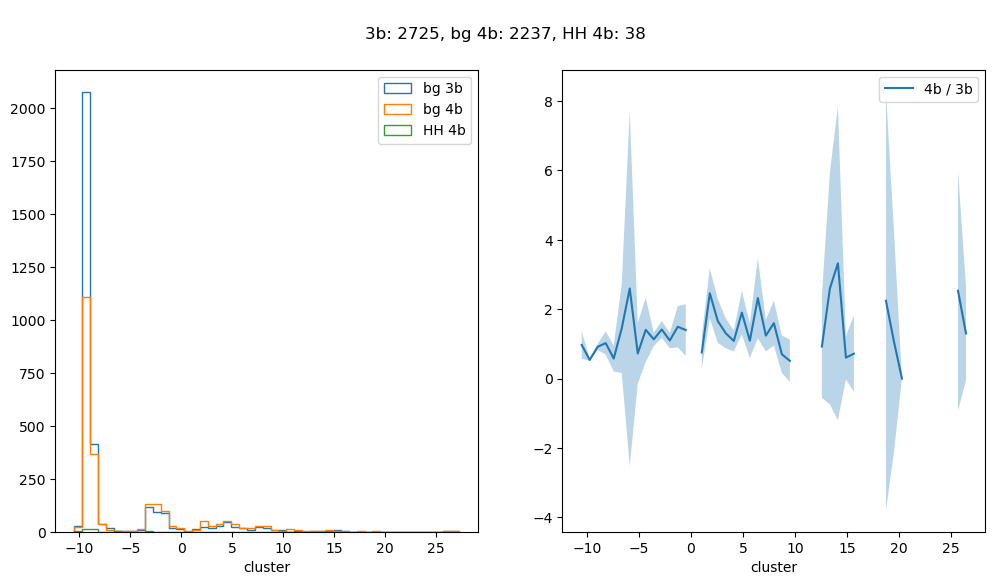

All samples
3b:  124922
bg4b:  118688
hh4b:  6246


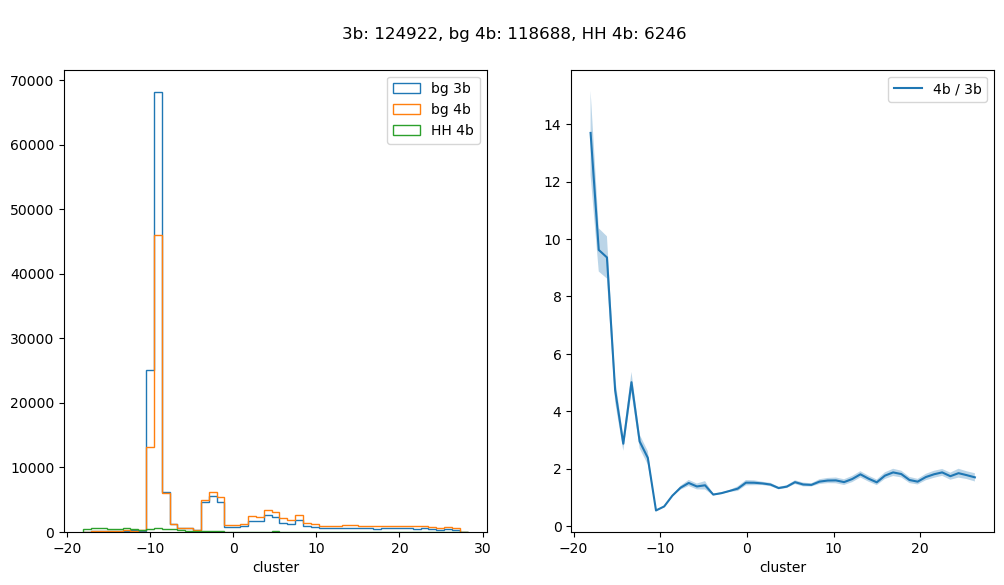

In [7]:
import umap
from sklearn.manifold import TSNE
from plots import plot_cluster

n_components = 1
umap_reducer = umap.UMAP(n_components=n_components, random_state=seed_)
# tsne_reducer = TSNE(n_components=n_components, random_state=seed_)

reducer = umap_reducer

# TSNE seems not to work well
# tsne_reducer.transform is not implemented
# reducer = tsne_reducer

# random sample of 10000 points

probs_4b_threshold = 0.6
probs_4b_exceeded = probs_4b_test > probs_4b_threshold

n_points = min(np.sum(probs_4b_exceeded), 5000)
np.random.seed(seed_)
cluster_samples = np.random.choice(np.where(probs_4b_exceeded)[0], n_points, replace=False)
# cluster_samples = np.random.choice(np.where(~probs_4b_exceeded)[0], n_points, replace=False)
# cluster_samples = np.random.choice(np.where(probs_4b_exceeded & (~is_signal_test))[0], n_points, replace=False)
q_repr_cluster = q_repr_test[cluster_samples]
is_3b_cluster = labels_4b_test[cluster_samples] == 0
is_bg4b_cluster = (labels_4b_test[cluster_samples] == 1) & (is_signal_test[cluster_samples] == 0)
is_hh4b_cluster = is_signal_test[cluster_samples] == 1
weights_cluster = w_test[cluster_samples]
view_scores_cluster = view_scores_test[cluster_samples]

# print number of points in each class
print("Thresholded samples")
print("3b: ", np.sum(is_3b_cluster))
print("bg4b: ", np.sum(is_bg4b_cluster))
print("hh4b: ", np.sum(is_hh4b_cluster))

# cluster_repr_test = umap_reducer.fit_transform(q_repr_cluster.reshape(-1, 3*dim_quadjet_features))

# plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)

att_q_repr_cluster = (q_repr_cluster @ view_scores_cluster[:, :, None]).reshape(-1, dim_quadjet_features)
cluster_repr_test = reducer.fit_transform(att_q_repr_cluster)

plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)


# failed samples
print("Failed samples")
print("3b: ", np.sum(is_3b_test & ~probs_4b_exceeded))
print("bg4b: ", np.sum(is_bg4b_test & ~probs_4b_exceeded))
print("hh4b: ", np.sum(is_hh4b_test & ~probs_4b_exceeded))

thrs_fail_samples = np.random.choice(np.where(probs_4b_test < probs_4b_threshold)[0], n_points, replace=False)
q_repr_fail = q_repr_test[thrs_fail_samples]
is_3b_fail = labels_4b_test[thrs_fail_samples] == 0
is_bg4b_fail = (labels_4b_test[thrs_fail_samples] == 1) & (is_signal_test[thrs_fail_samples] == 0)
is_hh4b_fail = is_signal_test[thrs_fail_samples] == 1
weights_fail = w_test[thrs_fail_samples]
view_scores_fail = view_scores_test[thrs_fail_samples]

att_q_repr_fail = (q_repr_fail @ view_scores_fail[:, :, None]).reshape(-1, dim_quadjet_features)
cluster_repr_fail = reducer.transform(att_q_repr_fail)

plot_cluster(cluster_repr_fail, is_3b_fail, is_bg4b_fail, is_hh4b_fail, weights_fail, n_components=n_components)

# all samples
print("All samples")
print("3b: ", np.sum(is_3b_test))
print("bg4b: ", np.sum(is_bg4b_test))
print("hh4b: ", np.sum(is_hh4b_test))

q_repr_all = q_repr_test
is_3b_all = labels_4b_test == 0
is_bg4b_all = (labels_4b_test == 1) & (is_signal_test == 0)
is_hh4b_all = is_signal_test == 1
weights_all = w_test
view_scores_all = view_scores_test

att_q_repr_all = (q_repr_all @ view_scores_all[:, :, None]).reshape(-1, dim_quadjet_features)
cluster_repr_all = reducer.transform(att_q_repr_all)

plot_cluster(cluster_repr_all, is_3b_all, is_bg4b_all, is_hh4b_all, weights_all, n_components=n_components)

<Figure size 1000x4200 with 0 Axes>

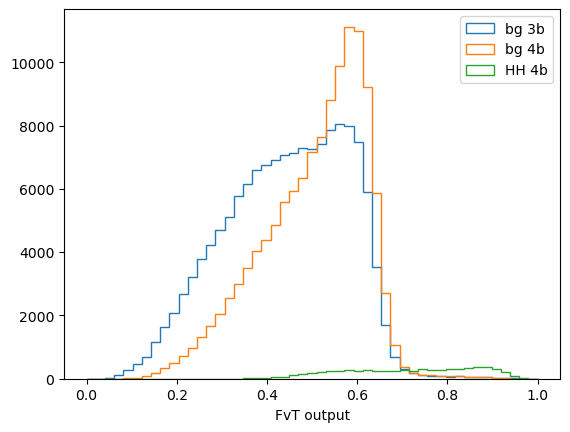

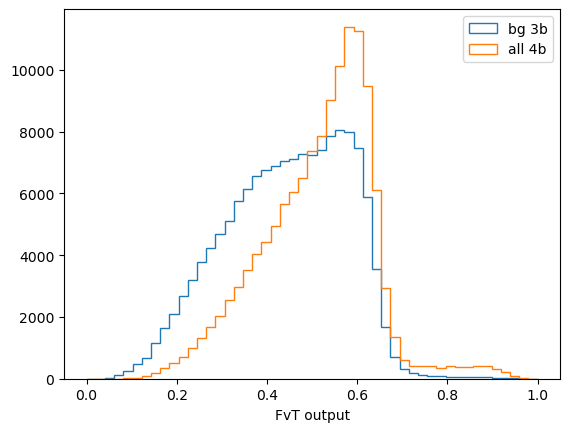

In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 3.5 * 2 * dim_quadjet_features))
outer = gridspec.GridSpec(2*dim_quadjet_features, 3, hspace=1.5, wspace=0.3)

is_3b_test = labels_4b_test == 0
is_4b_test = labels_4b_test == 1
is_bg4b_test = (labels_4b_test == 1) & (is_signal_test == 0)
is_hh4b_test = (labels_4b_test == 1) & (is_signal_test == 1)
plot_density = True
bins_range = np.linspace(0, 1, 50)

fig, ax = plt.subplots()
ax.hist(probs_4b_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
ax.hist(probs_4b_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
ax.hist(probs_4b_test[is_hh4b_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_hh4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()

fig, ax = plt.subplots()
ax.hist(probs_4b_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
ax.hist(probs_4b_test[is_4b_test], bins=bins_range, label="all 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()
plt.close()
